In [1]:
from src.rel_prop.min_max_rel_model import MinMaxModel, Nested_Regressor
from src.models.Binary_Mnist_Model import Montavon_Classifier
import numpy as np
from src.rel_prop.minmax_utils import get_higher_relevances
import matplotlib.pyplot as plt

In [2]:
mc = Montavon_Classifier(class_nb=8, load_model=True)
mc.set_data(test_size=0.2)
mc.set_model()
mc.model.summary()
mc.fit_model(epochs=100, batch_size=32)


Train images: 21840, train labels: 21840
Load model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 400)               313600    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               40000     
_________________________________________________________________
dense_2 (Dense)              (None, 400)               40000     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 400       
Total params: 394,000
Trainable params: 353,600
Non-trainable params: 40,400
_________________________________________________________________
Model has been load, no need to train!


In [3]:
# use to recalc relevances for the training of the min max model. Therefore set recalc_rel to True


In [4]:
minmax = MinMaxModel(classifier=mc, use_higher_rel=True)



Started to collect relevances to train min-max-model!
Info: You decided to use higher relevances for training.
Load relevances to train min-max-model from local directory!
Created MinMaxModel


In [5]:
nr_train_images = minmax.nr_train_images
true_relevances = minmax.true_relevances
higher_relevances = minmax.higher_relevances

minmax.train_min_max(pretrained=True)



Start Training of Min-Max-Model
Created nested regressor for neuron with index 0
Created nested regressor for neuron with index 1
Created nested regressor for neuron with index 2
Created nested regressor for neuron with index 3
Created nested regressor for neuron with index 4
Created nested regressor for neuron with index 5
Created nested regressor for neuron with index 6
Created nested regressor for neuron with index 7
Created nested regressor for neuron with index 8
Created nested regressor for neuron with index 9
Created nested regressor for neuron with index 10
Created nested regressor for neuron with index 11
Created nested regressor for neuron with index 12
Created nested regressor for neuron with index 13
Created nested regressor for neuron with index 14
Created nested regressor for neuron with index 15
Created nested regressor for neuron with index 16
Created nested regressor for neuron with index 17
Created nested regressor for neuron with index 18
Created nested regressor for

In [6]:
idx = 71
final_relevance, zplus_relevance = minmax.min_max_rel_prop(idx)
a = 1

Start Relevance Propagation
Starte Relevance Propagation für Nested Regressor mit Neuron Index 0
Starte Relevance Propagation für Nested Regressor mit Neuron Index 1
Starte Relevance Propagation für Nested Regressor mit Neuron Index 2
Starte Relevance Propagation für Nested Regressor mit Neuron Index 3
Starte Relevance Propagation für Nested Regressor mit Neuron Index 4
Starte Relevance Propagation für Nested Regressor mit Neuron Index 5
Starte Relevance Propagation für Nested Regressor mit Neuron Index 6
Starte Relevance Propagation für Nested Regressor mit Neuron Index 7
Starte Relevance Propagation für Nested Regressor mit Neuron Index 8
Starte Relevance Propagation für Nested Regressor mit Neuron Index 9
Starte Relevance Propagation für Nested Regressor mit Neuron Index 10
Starte Relevance Propagation für Nested Regressor mit Neuron Index 11
Starte Relevance Propagation für Nested Regressor mit Neuron Index 12
Starte Relevance Propagation für Nested Regressor mit Neuron Index 13
St

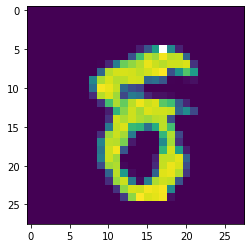

In [8]:
import numpy as np
from src.plotting.plot_funcs import plotly_mnist_image
final_relevance = final_relevance[0]
plotly_mnist_image(final_relevance[0])